# Guia 6

## Ejercicio 1

Implemente las estructuras de datos y algorítmos básicos para la solución de un problema mediante algorítmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de las siguientes funciones:

- $f(x) = -xsin(\sqrt{|x|}$ con $x \in [-512...512]$
- $f(x,y) = (x^2+y^2)^{0.25} [sin^2(50(x^2+y^2)^{0.1})+1]$, con $x,y \in [-100...100]$, como se puede ver en la siguiente figura

![](https://raw.githubusercontent.com/Lucasa98/Inteligencia-Computacional-2025/refs/heads/main/rsc/g6e1.png)

In [1]:
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from Evol import Evol

def f1(x):
    x = np.atleast_1d(x)
    f = -x*np.sin(np.sqrt(np.abs(x)))
    return f if f.shape[0] > 1 else f[0]

def df1(x):
    x = np.atleast_1d(x)
    df = -np.sin(np.sqrt(np.abs(x))) - ((np.power(x,2)*np.cos(np.sqrt(np.abs(x)))) / (2*np.abs(x)*np.sqrt(np.abs(x))))
    return df if df.shape[0] > 1 else df[0]

rng1 = np.random.default_rng()

# Metodo del gradiente
grad_ini = rng1.random(1,dtype=float)[0]*1024-512
grad = grad_ini
c_it = 0
while(np.abs(df1(grad)) > 0.001):
    c_it += 1
    grad = grad - df1(grad)
print(f"Iteraciones por metodo de gradiente = {c_it}")

Iteraciones por metodo de gradiente = 32


In [2]:
# ===== Algoritmo evolutivo =====
# funcion de decodificacion
def bit2float(x, xmin=-512, xmax=512) -> np.ndarray:
    """
    Convierte cromosomas binarios en números reales en [x_min, x_max].
    x: array 2D (N individuos, B bits)
    """
    x = np.atleast_2d(x)
    N, B = x.shape
    potencias = 1 << np.arange(B-1, -1, -1, dtype=np.uint64) 
    ints = (x * potencias).sum(axis=1)
    norm = ints / (2**B - 1)   
    floats = xmin + norm * (xmax - xmin)
    return floats if N > 1 else floats[0]


#función de codificacion
def float2bit(x, B, x_min=-512, x_max=512) -> np.ndarray:
    """
    Codifica valores reales en cromosomas binarios
    x: array de floats en [x_min, x_max]
    B: cantidad de bits por variable
    """
    x = np.atleast_1d(x)
    norm = (x - x_min) / (x_max - x_min) 
    ints = np.clip(np.round(norm * (2**B - 1)), 0, 2**B - 1).astype(np.uint64)
    bits = ((ints[:, None] >> np.arange(B-1, -1, -1)) & 1).astype(np.uint8)
    return bits if len(x) > 1 else bits[0]

def init_poblacion(pob: int, n_bits: int, rng: np.random.Generator) -> np.ndarray[np.uint8]:
    # inicializar la poblacion al azar
    return rng.integers(0,2,(pob,n_bits),dtype=np.uint8)

def fitness(x: np.ndarray[np.uint8]) -> np.ndarray[float]|float:
    # penalizamos los valores mas altos
    floats = bit2float(x)
    return -f1(floats)

evol = Evol(
    init_fun=init_poblacion,
    fit_fun=fitness,
    max_gen=20,
    poblacion=200,
    progenitores=20,
    mutacion=0.01,
    long_cromosoma=8,
    tolerancia=5
)

poblacion = evol.evolve()

 20%|██        | 4/20 [00:00<00:00, 322.84it/s]


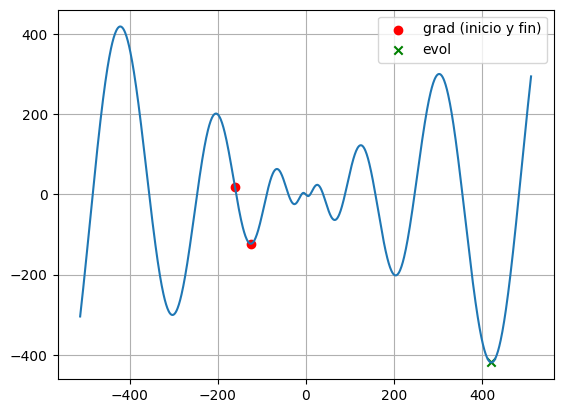

In [3]:
fit = fitness(poblacion)
sorted = np.argsort(fit)
ganador = poblacion[sorted[-1]] # mejor individuo
resultados = bit2float(ganador)
# Grafica de la funcion
x = np.arange(-512, 512, 1)
y = f1(x)

fig, ax = plt.subplots(1)
ax.grid()
ax.plot(x,y)
ax.scatter([grad_ini,grad],[f1(grad_ini),f1(grad)], c='r', label='grad (inicio y fin)')
ax.scatter(resultados, f1(resultados), c='g', label='evol', marker='x')
_ = ax.legend()

In [4]:
def f2(xy):
    """
    xy: array con [x, y] o array 2D [[x1, y1], [x2, y2], ...]
    Devuelve f2(x, y)
    """
    xy = np.atleast_2d(xy)
    x=xy[:, 0]
    y=xy[:, 1]  
    r2=x**2 + y**2
    f=r2**0.25*(np.sin(50*r2**0.1)**2 + 1)
    return f if f.shape[0] > 1 else f[0]

def df2(xy, eps=1e-6):
    """
    Gradiente numérico de f2 en (x, y)
    Devuelve un array [df/dx, df/dy].
    """
    xy = np.atleast_2d(xy)
    df=np.zeros_like(xy, dtype=float)
    for i in range(xy.shape[1]):
        dxy=np.zeros_like(xy, dtype=float)
        dxy[:, i]=eps
        df[:, i]=(f2(xy+dxy)-f2(xy-dxy))/(2*eps)
    return df if df.shape[0] > 1 else df[0] 

#función de codificación
def coord2bits(xy, B, xy_min=-100, xy_max=100) -> np.ndarray:
    """
    Codifica (x,y) reales en cromosomas binarios de 2*B bits.
    xy: array Nx2 con valores reales
    """
    xy = np.atleast_2d(xy)
    x_vals = xy[:, 0]
    y_vals = xy[:, 1]

    x_bits = float2bit(x_vals, B, xy_min, xy_max)
    y_bits = float2bit(y_vals, B, xy_min, xy_max)

    bits = np.hstack([x_bits, y_bits])
    return bits if xy.shape[0] > 1 else bits[0]

#función de decodificación
def bits2coord(bits, xy_min=-100, xy_max=100) -> np.ndarray:
    """
    Convierte cromosomas binarios de 2*B bits en (x,y) reales
    bits: array 2D (N individuos, 2*B bits)
    """
    bits = np.atleast_2d(bits)
    N, B = bits.shape
    if B%2 != 0:
        raise ValueError("El número total de bits debe ser par")
    B = B // 2

    x_bits = bits[:, :B]
    y_bits = bits[:, B:]

    x_vals = bit2float(x_bits, xy_min, xy_max)
    y_vals = bit2float(y_bits, xy_min, xy_max)

    xy = np.column_stack([x_vals, y_vals])
    return xy if N > 1 else xy[0]

def fitness2(xy: np.ndarray[np.uint8]) -> np.ndarray[float]|float:
    floats = bits2coord(xy)
    return -f2(floats)

def init_poblacion2(pob: int, n_bits: int, rng: np.random.Generator) -> np.ndarray[np.uint8]:
    # inicializar la poblacion al azar
    poblacion = rng.integers(0,2,(pob,n_bits),dtype=np.uint8)
    return poblacion

evol2 = Evol(
    init_fun=init_poblacion2,
    fit_fun=fitness2,
    max_gen=20,
    poblacion=200,
    progenitores=20,
    mutacion=0.01
)

poblacion2 = evol2.evolve()

 20%|██        | 4/20 [00:00<00:00, 316.74it/s]


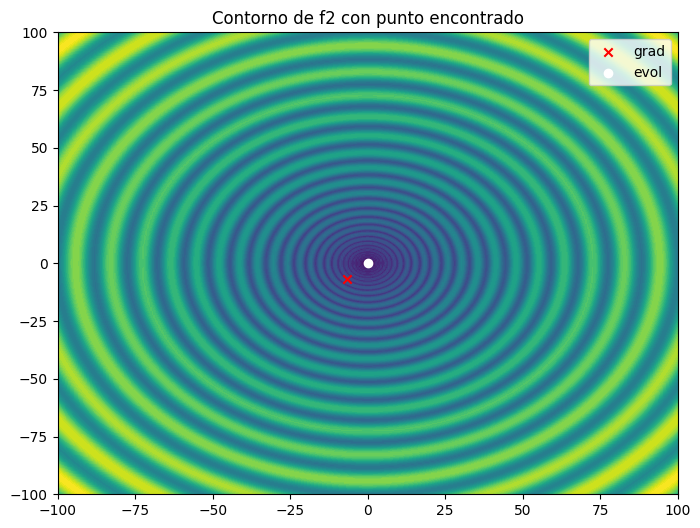

In [ ]:
fit2 = fitness2(poblacion2)
sorted2 = np.argsort(fit2)
ganador2 = poblacion2[sorted2[-1]] # mejor individuo
resultados2 = bits2coord(ganador2) 
#graficar
xy_min = -100
xy_max = 100
x = np.linspace(xy_min, xy_max, 400)
y = np.linspace(xy_min, xy_max, 400)
X, Y = np.meshgrid(x, y)
Z = f2(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.contourf(X, Y, Z, levels=50, cmap='viridis')
ax.scatter([resultados2[0]], [resultados2[1]], c='r', label='grad', marker='x')
ax.scatter([0], [0], c='w', label='evol', marker='o')
ax.set_title('Contorno de f2 con punto encontrado')
ax.legend()